# Proyecto 03 - Procesamiento del Lenguaje Natural

## Dataset: The Multilingual Amazon Reviews Corpus

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Es un archivo .zip que contiene tres documentos. Más información sobre el dataset [aquí](https://registry.opendata.aws/amazon-reviews-ml/). Es importante que tengas en cuenta la [licencia](https://docs.opendata.aws/amazon-reviews-ml/license.txt) de este dataset.**

### Exploración de datos y Procesamiento del Lenguaje Natural

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Considera que hasta que no hayas aplicado las herramientas de Procesamiento del Lenguaje Natural vistas, será difícil completar este análisis. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿qué palabras están asociadas a calificaciones positivas y qué palabras a calificaciones negativas?

### Machine Learning

Implementa un modelo que, dada la crítica de un producto, asigne la cantidad de estrellas correspondiente. **Para pensar**: ¿es un problema de Clasificación o de Regresión?

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?

**Recomendación:** si no te resulta conveniente trabajar en español con NLTK, te recomendamos que explores la librería [spaCy](https://spacy.io/).

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Valdrá la pena convertir el problema de Machine Learning en un problema binario? Es decir, asignar únicamente las etiquetas Positiva y Negativa a cada crítica y hacer un modelo que, en lugar de predecir las estrellas, prediga esa etiqueta. Pensar en qué situación puede ser útil. ¿Esperas que el desempeño sea mejor o peor?

# FLUJO DE TRABAJO

# 1 - Obtencion de datos

In [260]:
#descargamos las librerias que vamos a usar y las configuraciones
import pandas as pd
import numpy as np
import string

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import nltk
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize

#Esto sirve para configurar NLTK. La primera vez puede tardar un poco
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Luigi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [261]:
dataset = pd.read_json(r'C:\Users\Luigi\Documents\02.Proj_Amazon-NLP\dataset_es_dev.json',lines=True)

# 2 - Exploracion de datos

In [262]:
dataset.head()

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0417480,product_es_0873923,reviewer_es_0672978,1,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,es,wireless
1,es_0180432,product_es_0713146,reviewer_es_0100858,1,No he recibido el pedido no la devolución,No lo he recibido,es,apparel
2,es_0144850,product_es_0356874,reviewer_es_0486447,1,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,es,sports
3,es_0339629,product_es_0939832,reviewer_es_0894703,1,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,es,home_improvement
4,es_0858362,product_es_0489066,reviewer_es_0887663,1,No me gusta su olor a viejo y aspecto malo,No me gusta,es,beauty


In [263]:
dataset.shape

(5000, 8)

Con esto nos damos cuenta de que los datos tienen 8 columnas y 5000 filas. Ademas, por el nombre de las cabeceras nos damos cuenta que muy posiblemente este dataset este estructurado mediante SQL. Vemos que hay tres IDs asociados: uno correspondiente a la review, otro relacionado al producto y otro a la critica. Tambien podemos ver que en esta tabla nos indica el lenguaje (importante para ver que tipos de librerias usamos) y ademas vemmos que los productos tienen una categoria asociada. Por ultimo vemos la cantidad de estrellas que se dio a ese producto dada la review.

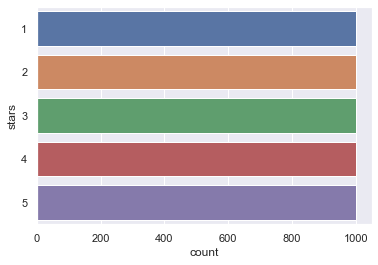

In [264]:
sns.countplot(data = dataset , y='stars')
plt.show()

#  📙 "Ver para clasificar por tipo de producto" 

Con esto vemos que de un total de 5000 registros, estos tienen una distribucion equiprobable segun su clasificacion. Ahora veamos un comentario random del dataset y como expresan los usuarios sus gustos..

In [265]:
index_random = np.random.randint(1,4000)
titular = dataset.review_body.iloc[index_random]
print(index_random, titular)
print(index_random, dataset.stars.iloc[index_random])

2993 Por ahora me parece bien
2993 3


A continuacion vemos algunos registros y como estos tienen asociado el titulo del review

In [266]:
dataset = dataset.iloc[:,[4,5,3]]
dataset.dropna(axis=0,inplace=True)  # Si hay alguna nan, tiramos esa instancia
dataset.head()

,review_body,review_title,stars
0,"Malisimo, muy grande demasiado aparatoso y mal...",Mala compra,1
1,No he recibido el pedido no la devolución,No lo he recibido,1
2,"Tengo que buscar otro sistema, este no funcion...",Que no aprieta bien en el manillar,1
3,Utilicé las brocas de menor diámetro y se me d...,Brocas de mantequilla,1
4,No me gusta su olor a viejo y aspecto malo,No me gusta,1


# 3 - Normalizacion

En esta etapa limpiaremos los caracteres, tokenizaremos y llevaremos a raiz las palabras del dataset mediante la stematizacion o lemmatizacion.

Comenzaremos desasiendonos de las palabras que tienen menos carga semantica para trabajar con los que tienen mayor ponderacion. Para ello traeremos el catalogo predefinido como stopword de la libreria NLTK

# 📙 que pasa si esta mezclado el dataset y no tengo SPANISH ENGLISH para filtrar? si el dataset es en castellaro o derivaciones de lenguas?

In [267]:
stopwords = nltk.corpus.stopwords.words('spanish')
stopwords = [palabra for palabra in stopwords if 'not' not in palabra]
#stopwords
print(stopwords)

['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'no', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestro', 'vuestra', 'vuestros', 'vuestras', 'esos', 'esas', 'estoy', 'estás', 'está', 'estamos', 'estáis', 'están', 'e

## 3.1 - Stemmer

In [268]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos la función que nos permite Stemmizar de nltk y definimos el stemmer
from nltk.stem import SnowballStemmer
# spanish_stemmer = SnowballStemmer('spanish')
# (spanish_stemmer.stem("texto_en_str"))
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()


In [269]:
# Recorremos todos los titulos y le vamos aplicando la Normalizacion y luega el Stemming a cada uno
review_list=[]
simb=["!",".",",","no","si","...",")","("]
todaslaspalabras=[]
for review in dataset.review_body:
    # Vamos a reemplzar los caracteres que no sean leras por espacios
    #review=re.sub(","," ",str(review))#borra los espacios y las tiles
    # Pasamos todo a minúsculas
    review=review.lower()
    # Tokenizamos para separar las palabras del titular
    review=nltk.word_tokenize(review)
    # Eliminamos las palabras de menos de 3 letras
    #dataset = [palabra for palabra in dataset if len(palabra)>2]
    # Sacamos las Stopwords
    review = [palabra for palabra in review if not palabra in stopwords if not palabra in simb]
    
    ## Hasta acá Normalizamos, ahora a stemmizar
    
    # Aplicamos la funcion para buscar la raiz de las palabras
    review=[stemmer.stem(palabra) for palabra in review]

    todaslaspalabras.append(review)
    # Por ultimo volvemos a unir el titular
    review=" ".join(review)
    
    # Vamos armando una lista con todos los titulares
    review_list.append(review)
    #dataset["titular_normalizado"] = titular_list

In [270]:
flat_list = [item for t in todaslaspalabras for item in t]
flat_list[0:30]

['malisimo',
 'grand',
 'demasiado',
 'aparatoso',
 'mal',
 'protector',
 'pantalla',
 'recibido',
 'pedido',
 'devolución',
 'buscar',
 'sistema',
 'funciona',
 'bien',
 'abrazadera',
 'lleva',
 'agarrar',
 'manillar',
 'aprieta',
 'bien',
 'deslizando',
 'linterna',
 'hacia',
 'abajo',
 'utilicé',
 'broca',
 'menor',
 'diámetro',
 'doblaron',
 'varia']

# 📙 Check por que tengo que correr todo de nuevo para que me muestre la list

In [271]:
review_list[0:10] #Porque tengo que correr todo de nuevo??????

['malisimo grand demasiado aparatoso mal protector pantalla',
 'recibido pedido devolución',
 'buscar sistema funciona bien abrazadera lleva agarrar manillar aprieta bien deslizando linterna hacia abajo',
 'utilicé broca menor diámetro doblaron varia mantequilla hacer mínima presión vez doblada intentar enderezarla parten exteriorment amarilla interior fundido gri peor compra hecho bastant tiempo',
 'gusta olor viejo aspecto malo',
 'hola despué recog paquet llegado bola rota',
 'part poder elegir color envian cesto color asa imagino aprovechando van rompiendo dicen color aleatorio foto cesta asa mismo color recomiendo comprarlo pueda elegir color único alivio romperá pronto calidad allá',
 'baja calidad ahí precio compra supon tirar dinero',
 'producto sale entregado recibido',
 'recomiendo pega acaba despegandos']

In [272]:
freq = nltk.FreqDist(flat_list)
freq

FreqDist({'bien': 1324, 'calidad': 742, 'producto': 642, 'precio': 534, 'buena': 509, 'bastant': 336, 'funciona': 282, 'buen': 272, 'pued': 263, 'día': 260, ...})

In [273]:
dataset["review_stem"] = review_list
dataset.tail()

,review_body,review_title,stars,review_stem
4995,Me ha encantado la cesta. Ha llegado impecable...,guadalupe,5,encantado cesta llegado impecable.tien tamaño ...
4996,Desempeña su función correctamente,calidad precio,5,desempeña función correctament
4997,Me ha encantado la diadema! Las flores son tal...,Excelente,5,encantado diadema flore tal vienen imagen vení...
4998,"A mi me gustan mucho las fundas TPU, ya que so...",Genial,5,gustan funda tpu funda normalment fina colorid...
4999,El artículo ha cumplido con las expectativas q...,Buena calidad,5,artículo cumplido expectativa deseaba


In [274]:
print(review_list)

['malisimo grand demasiado aparatoso mal protector pantalla', 'recibido pedido devolución', 'buscar sistema funciona bien abrazadera lleva agarrar manillar aprieta bien deslizando linterna hacia abajo', 'utilicé broca menor diámetro doblaron varia mantequilla hacer mínima presión vez doblada intentar enderezarla parten exteriorment amarilla interior fundido gri peor compra hecho bastant tiempo', 'gusta olor viejo aspecto malo', 'hola despué recog paquet llegado bola rota', 'part poder elegir color envian cesto color asa imagino aprovechando van rompiendo dicen color aleatorio foto cesta asa mismo color recomiendo comprarlo pueda elegir color único alivio romperá pronto calidad allá', 'baja calidad ahí precio compra supon tirar dinero', 'producto sale entregado recibido', 'recomiendo pega acaba despegandos', 'desliza hacia abajo rato hecho materi baja calidad recomiendo', 'do mese despué llegado amazon debe convertir mercadillo vendedor china', 'funciona recog absolutament recomiendo ab

In [275]:
df_freq = pd.DataFrame(list(freq.items()), columns = ["Word", "Frecuency"])
df_freq.sort_values('Frecuency',ascending=False, inplace = True)
df_freq.head(20)

,Word,Frecuency
13,bien,1324
83,calidad,742
91,producto,642
87,precio,534
563,buena,509
46,bastant,336
12,funciona,282
1203,buen,272
261,pued,263
124,día,260


In [276]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [277]:
import re, string

def remove_punctuation ( flat_list ):
  return re.sub('[%s]' % re.escape(string.punctuation), ' ', text)

df_freq = pd.DataFrame(list(freq.items()), columns = ["Word", "Frecuency"])
df_freq.sort_values('Frecuency',ascending=False, inplace = True)
df_freq.head()

,Word,Frecuency
13,bien,1324
83,calidad,742
91,producto,642
87,precio,534
563,buena,509


In [278]:
Good = list(itertools.chain(*freq))
Good[0:10]

['b', 'i', 'e', 'n', 'c', 'a', 'l', 'i', 'd', 'a']

In [279]:
print(nltk.word_tokenize(review))

['artículo', 'cumplido', 'expectativa', 'deseaba']


Falta distribucion de frecuencia de palabras con seaborn.
Ver la frecuencia de palabras ahora segmentado por rubro

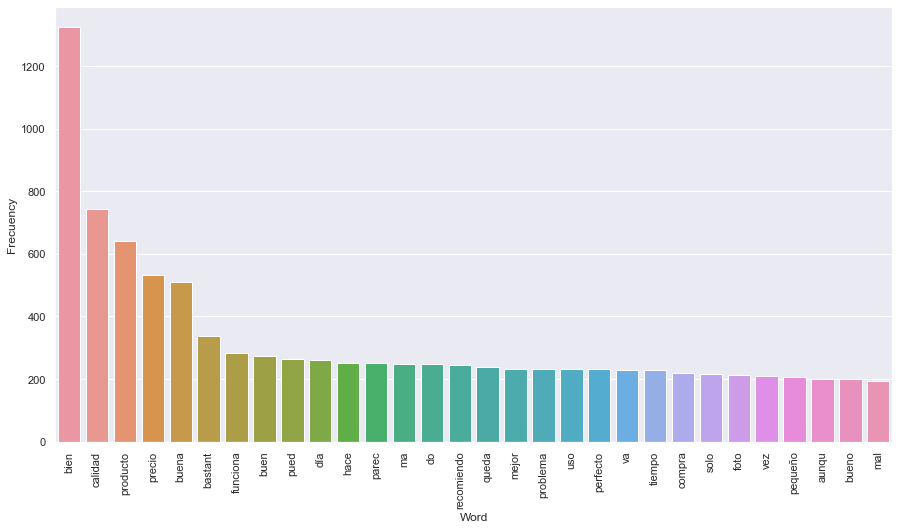

In [280]:
plt.figure(figsize = (15,8))
plot = sns.barplot(x  = df_freq.iloc[:30].Word, y = df_freq.iloc[:30].Frecuency)
for item in plot.get_xticklabels():
    item.set_rotation(90)
plt.show()

## 3.1 - Lemmatizacion

In [281]:
# Importamos esta libreria que nos permite reemplzar caracteres
import re

# Importamos el lemmatizar de NLTK, y creamos el objeto
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

In [290]:
# Oracion que usaremos como ejemplo
frase = "I buy something with a good description but it was a waste of time."
#resulta compré descripción buena garantía resulta tiempo romp justo soporta part abajo carcasa provocando caída rompies cristal móvil decepcion carcasa realment."

# Hay que regularizar el texto. Dejar solo letra, pasar a minúsculas y tokenizar:

# Sacamos todo lo que no sean letras
frase = re.sub("[^a-zA-Z]"," ",str(frase))
# Pasamos a minúsculas
frase = frase.lower()
# Tokenizamos
frase_tokens = nltk.word_tokenize(frase)

# Veamos como cambians las palabras al lemmatizar
print("{0:20}{1:20}".format("Word","Lemma"))
for palabra in frase_tokens:
    print ("{0:20}{1:20}".format(palabra,wordnet_lemmatizer.lemmatize(palabra)))

Word                Lemma               
i                   i                   
buy                 buy                 
something           something           
with                with                
a                   a                   
good                good                
description         description         
but                 but                 
it                  it                  
was                 wa                  
a                   a                   
waste               waste               
of                  of                  
time                time                


In [291]:
print(nltk.pos_tag(frase_tokens))

[('i', 'JJ'), ('buy', 'VBP'), ('something', 'NN'), ('with', 'IN'), ('a', 'DT'), ('good', 'JJ'), ('description', 'NN'), ('but', 'CC'), ('it', 'PRP'), ('was', 'VBD'), ('a', 'DT'), ('waste', 'NN'), ('of', 'IN'), ('time', 'NN')]


In [292]:
from nltk.corpus import wordnet

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [293]:
frase_lemma = [wordnet_lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(frase)]
tipo_palabra = [get_wordnet_pos(w) for w in nltk.word_tokenize(frase)]

# Veamos como cambiaron las palabras
print("{0:20}{1:20}{2:20}".format("Palabra:","Tipo:","Lemma:"))
for i in range(len(frase_tokens)):
    print ("{0:20}{1:20}{2:20}".format(frase_tokens[i],tipo_palabra[i],frase_lemma[i]))

Palabra:            Tipo:               Lemma:              
i                   n                   i                   
buy                 v                   buy                 
something           n                   something           
with                n                   with                
a                   n                   a                   
good                a                   good                
description         n                   description         
but                 n                   but                 
it                  n                   it                  
was                 v                   be                  
a                   n                   a                   
waste               n                   waste               
of                  n                   of                  
time                n                   time                


# 📙 Toma al recomendar como un noun y no como un verbo. Pareciera ser que el Lemma solo clasifica correctamente las palabras en INgles

# 4 - Vectorizacion

# 5 - Modelado